In [10]:
# for math operations
import pandas as pd
import numpy as np

# for progress bar
from tqdm import tqdm

# for data preprocessing
import re
import os
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer

# Model building
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.ensemble import RandomForestClassifier
import pickle

# for plotting
import matplotlib.pyplot as plt
%matplotlib inline

nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\nguye\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [8]:
def cleanText(str):
  return ' '.join(re.sub('[^A-Za-z ]+', '', str.lower()).split()).replace('subject', '').strip()

# Preprocess datasets

In [103]:
# datasets = pd.read_csv('../datasets/emails.csv')
# X_train = datasets.iloc[0:5169, 1:3001].values
# Y_train = datasets.iloc[0:5169, 3001].values
# X_test = datasets.iloc[5169:5172, 1:3001].values

legit_dataset_path = '../datasets/enron1/ham'
spam_dataset_path = '../datasets/enron1/spam'
combined_path = '../datasets/enron1'

legit_dataset = []
legit_label = []
spam_dataset = []
spam_label = []
for file_name in os.listdir(legit_dataset_path):
  with open(os.path.join(legit_dataset_path, file_name), 'r', encoding='utf8') as f:
    text = cleanText(f.read())
    if text:
      legit_dataset.append(text)
      legit_label.append('0')

for file_name in os.listdir(spam_dataset_path):
  with open(os.path.join(spam_dataset_path, file_name), 'r', encoding='utf8') as f:
    text = cleanText(f.read())
    if text:
      spam_dataset.append(text)
      spam_label.append('1')

train_dataset = legit_dataset + spam_dataset
train_label = legit_label + spam_label
dict = {'Text': train_dataset, 'Predict': train_label}

df = pd.DataFrame(dict)

df.to_csv(combined_path + '/train_dataset.csv')


# Load dataset

In [104]:
dataset = pd.read_csv('../datasets/enron1/train_dataset.csv')
dataset.tail()

,Unnamed: 0,Text,Predict
5142,5142,our pro forma invoice attacheddivide cover mos...,1
5143,5143,str rndlen extra time word bodyhtml,1
5144,5144,check me out bbhey dermbbbbbcheck out paris an...,1
5145,5145,hot jobsglobal marketing specialties po box ea...,1
5146,5146,save up to on ink no shipping costsave up to o...,1


In [105]:
def freqWord(word, str):
  return str.lower().split().count(word.lower())

In [106]:
dataset.shape

(5147, 3)

In [116]:
dataset = dataset[['Text', 'Predict']]

In [108]:
dataset.Predict.unique()

array([0, 1], dtype=int64)

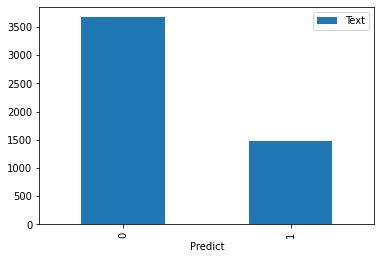

In [110]:
dataset.groupby('Predict').count().plot.bar(ylim=0)
plt.show()

# Text processing

In [131]:
def preprocessText(str):
  return ' '.join([stemmer.stem(i) for i in re.sub('[^a-zA-Z]', ' ', str).split() if i not in words])

In [117]:
stemmer = PorterStemmer()
words = stopwords.words("english")

dataset['Text'] = dataset['Text'].apply(
  lambda x: ' '.join([stemmer.stem(i) for i in re.sub('[^a-zA-Z]', ' ', x).split() if i not in words]))

In [118]:
dataset

,Text,Predict
0,christma tree farm pictur,0
1,vastar resourc inc gari product high island la...,0
2,calpin daili ga nomin calpin daili ga nomin doc,0
3,issuefyi see note alreadi done stella forward ...,0
4,meter nov allocationfyi forward lauri allen ho...,0
...,...,...
5142,pro forma invoic attacheddivid cover gave trip...,1
5143,str rndlen extra time word bodyhtml,1
5144,check bbhey dermbbbbbcheck pari mani celeb atbl,1
5145,hot jobsglob market specialti po box east amhe...,1


# Feature Extraction

In [120]:
vectorizer = TfidfVectorizer(min_df= 3, stop_words="english", sublinear_tf=True, norm='l2', ngram_range=(1, 2))
final_features = vectorizer.fit_transform(dataset['Text']).toarray()
final_features.shape

(5147, 33294)

# Model building

In [127]:
X = dataset['Text']
Y = dataset['Predict']

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.1)
pipeline = Pipeline([('vect', vectorizer),
                    ('chi',  SelectKBest(chi2, k=1200)),
                    ('clf', RandomForestClassifier())])

model = pipeline.fit(X_train, y_train)
with open('SpamMailRF.pickle', 'wb') as f:
  pickle.dump(model, f)


# Evaluate

In [128]:
ytest = np.array(y_test)

# confusion matrix and classification report(precision, recall, F1-score)
print(classification_report(ytest, model.predict(X_test)))
print(confusion_matrix(ytest, model.predict(X_test)))

              precision    recall  f1-score   support

           0       0.96      0.99      0.98       349
           1       0.99      0.91      0.95       166

    accuracy                           0.97       515
   macro avg       0.97      0.95      0.96       515
weighted avg       0.97      0.97      0.97       515

[[347   2]
 [ 15 151]]


Text(0.5, 1.0, 'Confusion Matrix')

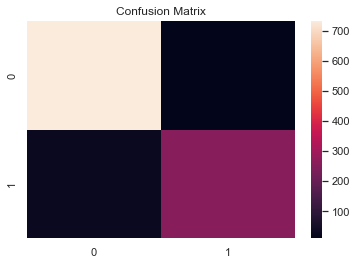

In [126]:
import seaborn as sns; sns.set()
ax = sns.heatmap(confusion_matrix(ytest, model.predict(X_test)))
plt.title('Confusion Matrix')

# Predict

In [134]:

test = ["Winning an unexpected prize sounds great in theory. However, being notified of winning a contest you didn’t enter is a dead giveaway of a phishing text. If you’re not sure whether an offer is authentic, contact the business directly to verify."
    , "The discussion on native speaker intuitions has been extremely interesting, but I worry that my brief intervention may have muddied the waters. I take it that there are a number of separable issues. The first is the extent towhich a native speaker is likely to judge a lexical string as grammatical or ungrammatical per se. The second is concerned with the relationships between syntax and interpretation (although even here the distinction may not be entirely clear cut). "
    , "financial freedom follow financial freedom work ethic extraordinary desire earn least per month work home special skills experience required train personal support need ensure success legitimate homebased income opportunity put back control finance life ve try opportunity past fail live promise"
    , "Dear User, All hotmail customers have been upgraded to Outlook.com. Your hotmail account services has expired. Due to our new system upgrade to outlook. In order for it to remain active follow the link Sign in Re-activate your account to Outlook. https://account.live.com"
    , "As part of our continued commitment to your privacy, we are updating the Western Digital Privacy Statement, Cookie Statement, and California Consumer Privacy Act (CCPA) Notice to reflect recent privacy law developments. The Privacy Statement governs our use of your data in relation to our products, services, marketing communications and support, including for our SanDisk, SanDisk Professional, WD, and Western Digital brands. The Cookie Statement discusses how we use cookies and other technologies in our websites, applications, emails, advertisements, and online services. Finally, the CCPA Notice contains important information about our data processing activities and legal rights for residents of California. We encourage you to review the updated documents in their entirety to understand how your data is collected, stored, processed, and shared by Western Digital and its affiliates. Your continued use of Western Digital products and services, including your continued participation in our marketing communications and support programs, acknowledges your acceptance of the updated Privacy Statement, Cookie Statement, and, if applicable, CCPA Notice. If you have any questions or comments, please Contact Us."]

thisTest=[]

for i in test:
    i = preprocessText(i)

X_predict = np.array(test)

# make a prediction
y_predict = model.predict(X_predict)

print("RANDOM FOREST MODEL Predicted = %s" % (y_predict))

RANDOM FOREST MODEL Predicted = [1 0 0 0 1]
